In [3]:
import os
import healpy as h
import collections
from modules.calc_EB_rec_noise.fast_calc_eb_rec_noise import calc_eb_rec_noise
from modules.calc_TB_rec_noise.fast_calc_tb_rec_noise import calc_tb_rec_noise
from modules import eb_rec
from modules import tb_rec


figpath="./figures_null_test/"

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
ensure_dir(figpath)

# jpegpath=figpath + "/jpeg/" ; ensure_dir(jpegpath)
datapath=figpath + "/data/" ; ensure_dir(datapath)
clr_lst=list(["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray",'#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231','#911eb4'])
# clr_lst=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [156]:
clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_totCls.dat")
clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_lensedCls.dat")

maxell=3500
ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
clee=clthry[:maxell+1,2]/fl ; clee=append([0.,0.],clee)
clbb=clthry[:maxell+1,3]/fl ; clbb=append([0.,0.],clbb)
clte=clthry[:maxell+1,4]/fl ; clte=append([0.,0.],clte)
ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
clthr=[cltt,clee,clbb,clte]

nside=1024
lmax=2048

<IPython.core.display.Javascript object>


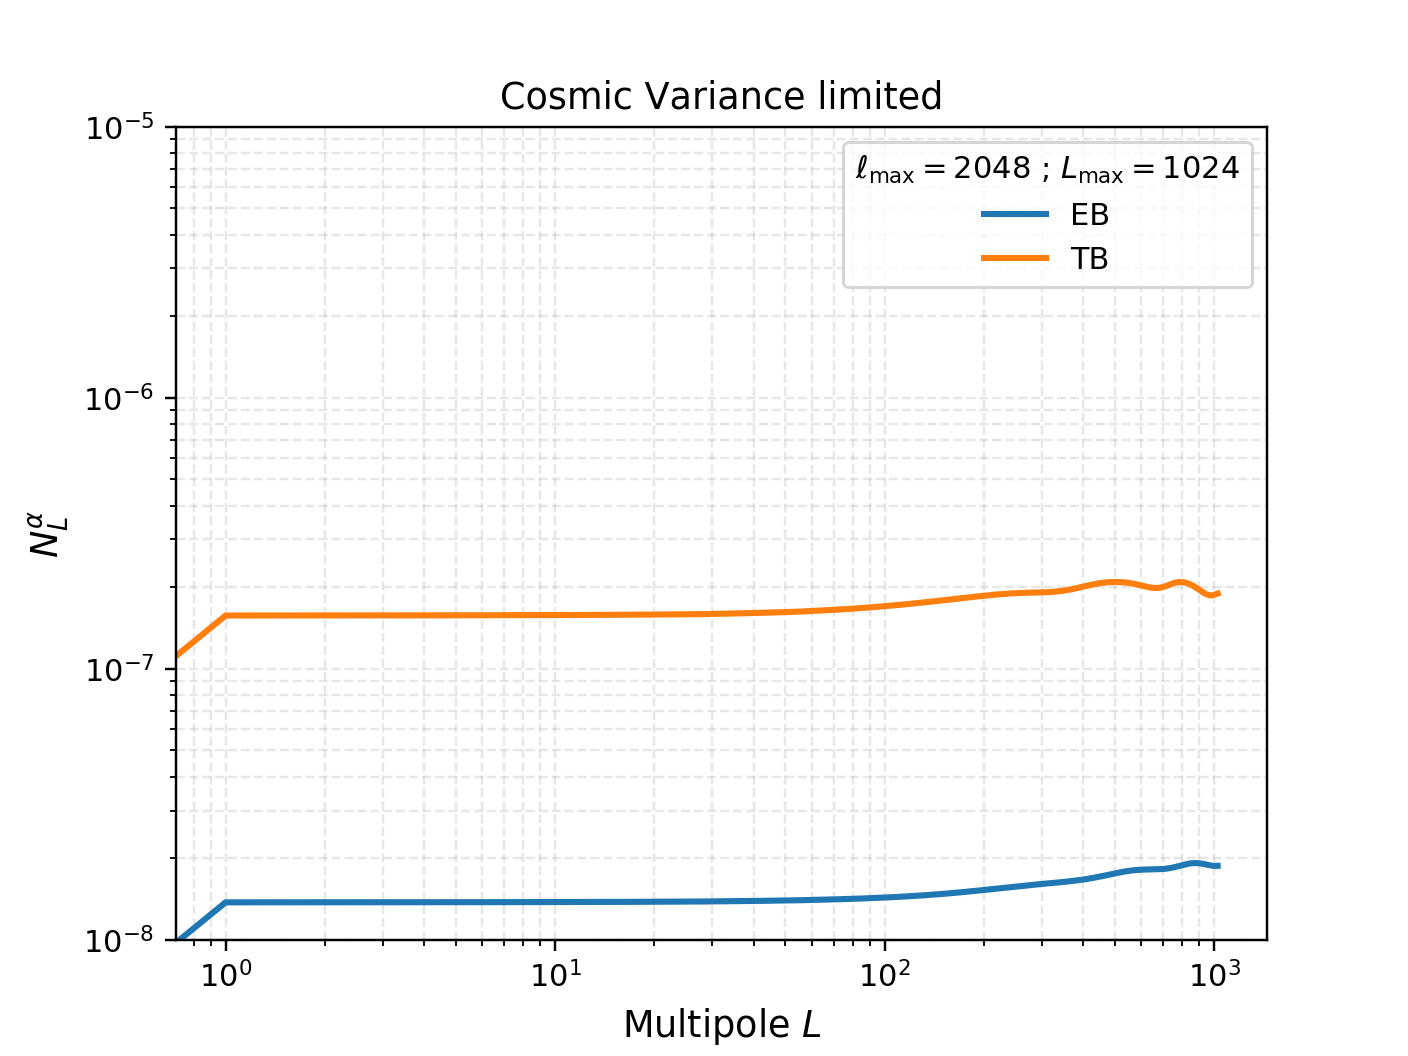

In [157]:
Lmax=1024
L=np.arange(Lmax+1)
NLeb=calc_eb_rec_noise(clee,clee,clbb,2,lmax,Lmax)
NLtb=calc_tb_rec_noise(clte,cltt,clbb,2,lmax,Lmax)

figure()
plot(L,NLeb,"-",lw=2,label="EB")
plot(L,NLtb,"-",lw=2,label="TB")
loglog()
ylabel(r"$N^{\alpha}_L$",fontsize=12)
xlabel(r"Multipole $L$",fontsize=12)
grid(which="both",alpha=0.3,linestyle="dashed")
legend(loc=0,title=r"$\ell_{\rm max}=$" + str(lmax) + " ; " + r"$L_{\rm max}=$"+str(Lmax) )
title("Cosmic Variance limited")
ylim(1e-8,1e-5)
figname=figpath + "eb_vs_tb_recnoise_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight")

# Simulate

Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


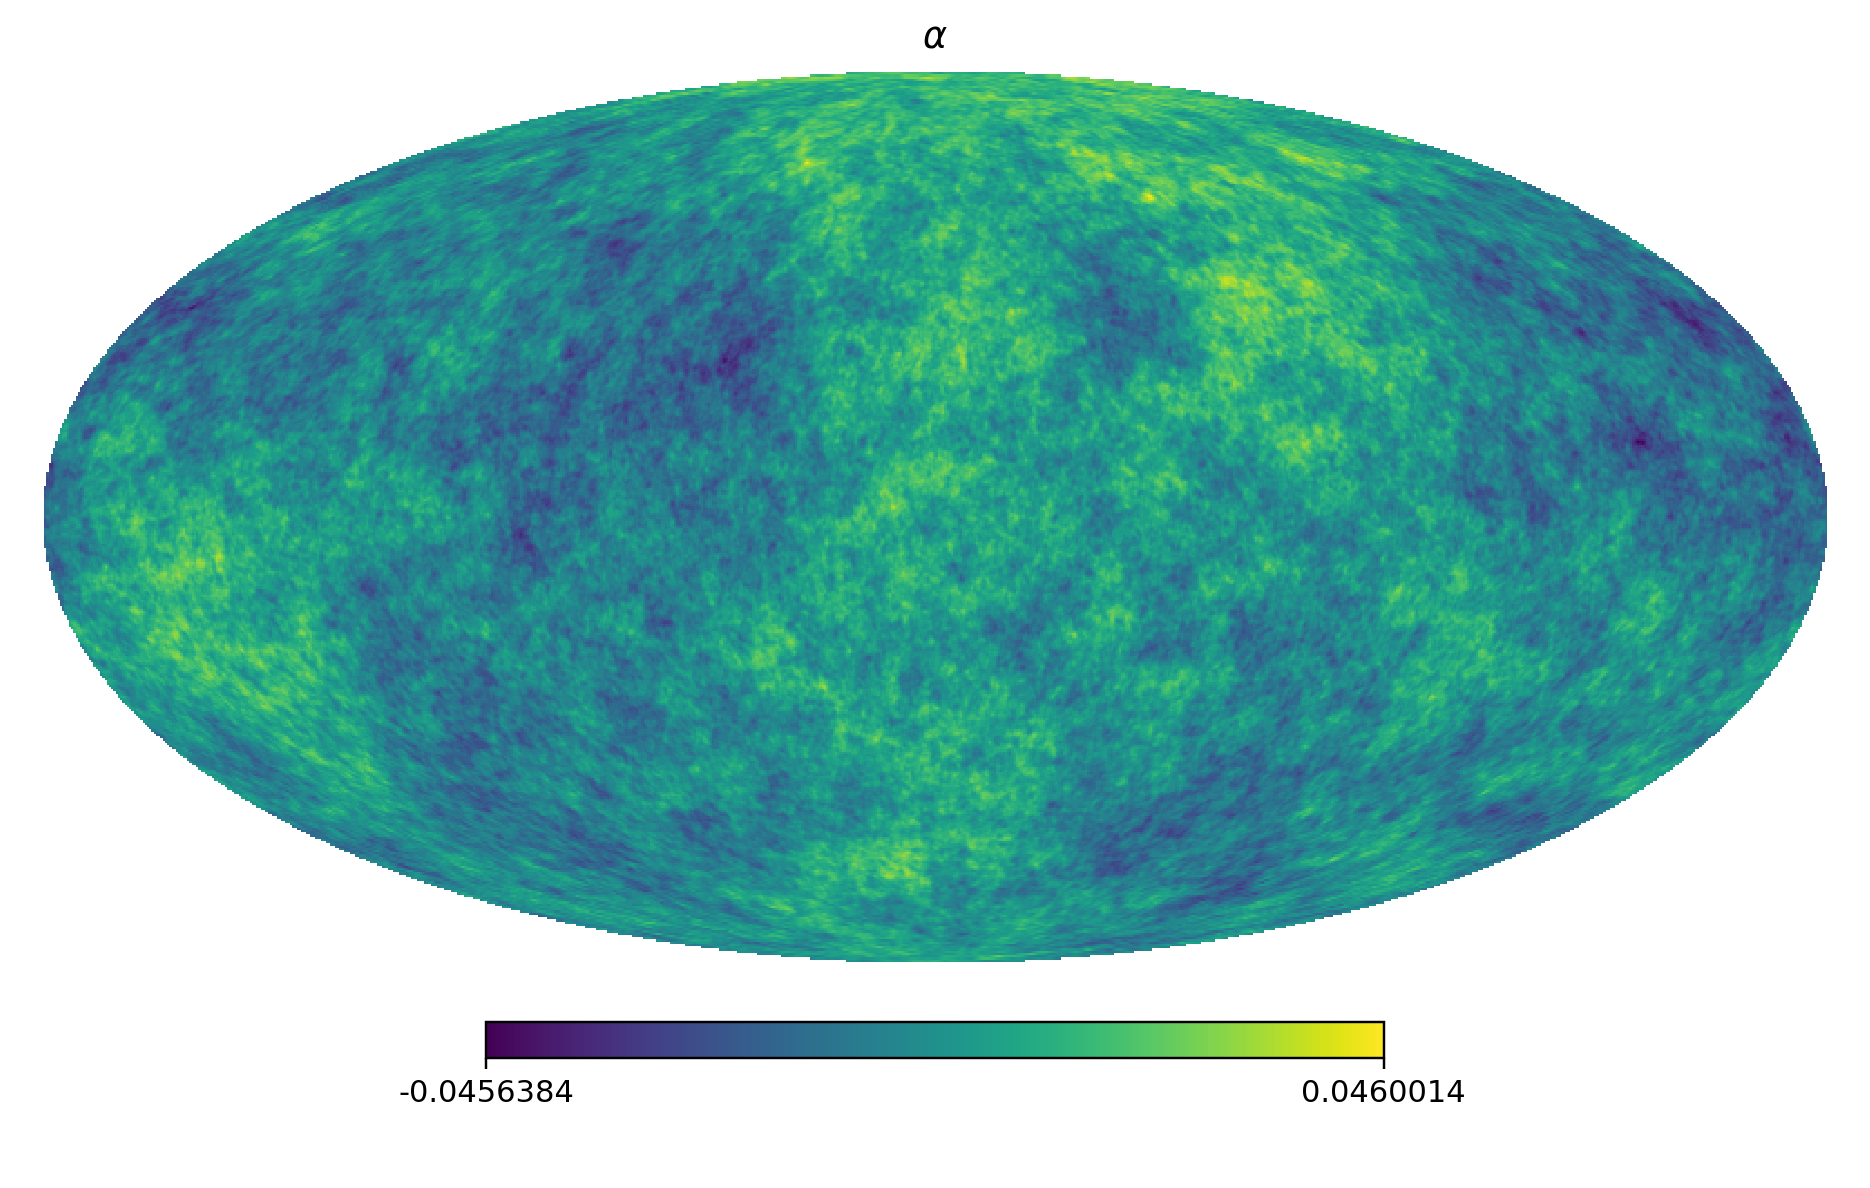

In [158]:
cmb=h.synfast(clthr,nside,new=True,pol=True,verbose=False,lmax=3*nside)

ell=np.arange(Lmax+1).astype(np.float64) ; cl_alpha=np.zeros_like(ell)
cl_alpha[1:]=1e-4*ell[1:]**-2.
# cl_alpha[1:]=1e-4
np.random.seed(0)
alpha=h.synfast(cls=cl_alpha,nside=nside,verbose=False)
clsig=h.alm2cl(h.map2alm(alpha,lmax=Lmax))

obs=np.zeros_like(cmb)
obs[0]=cmb[0]
obs[1]=cmb[1] - alpha*cmb[2]
obs[2]=cmb[2] + alpha*cmb[1]


h.mollview(h.smoothing(alpha,fwhm=(30./60.)*np.pi/180.),title=r"$\alpha$")
figname=figpath + "smoothed_alpha.pdf"
savefig(figname,bbox_inches="tight")

In [159]:
clobs=h.alm2cl(h.map2alm(obs,lmax=lmax,pol=True))
clcmb=h.alm2cl(h.map2alm(cmb,lmax=lmax,pol=True))

<IPython.core.display.Javascript object>


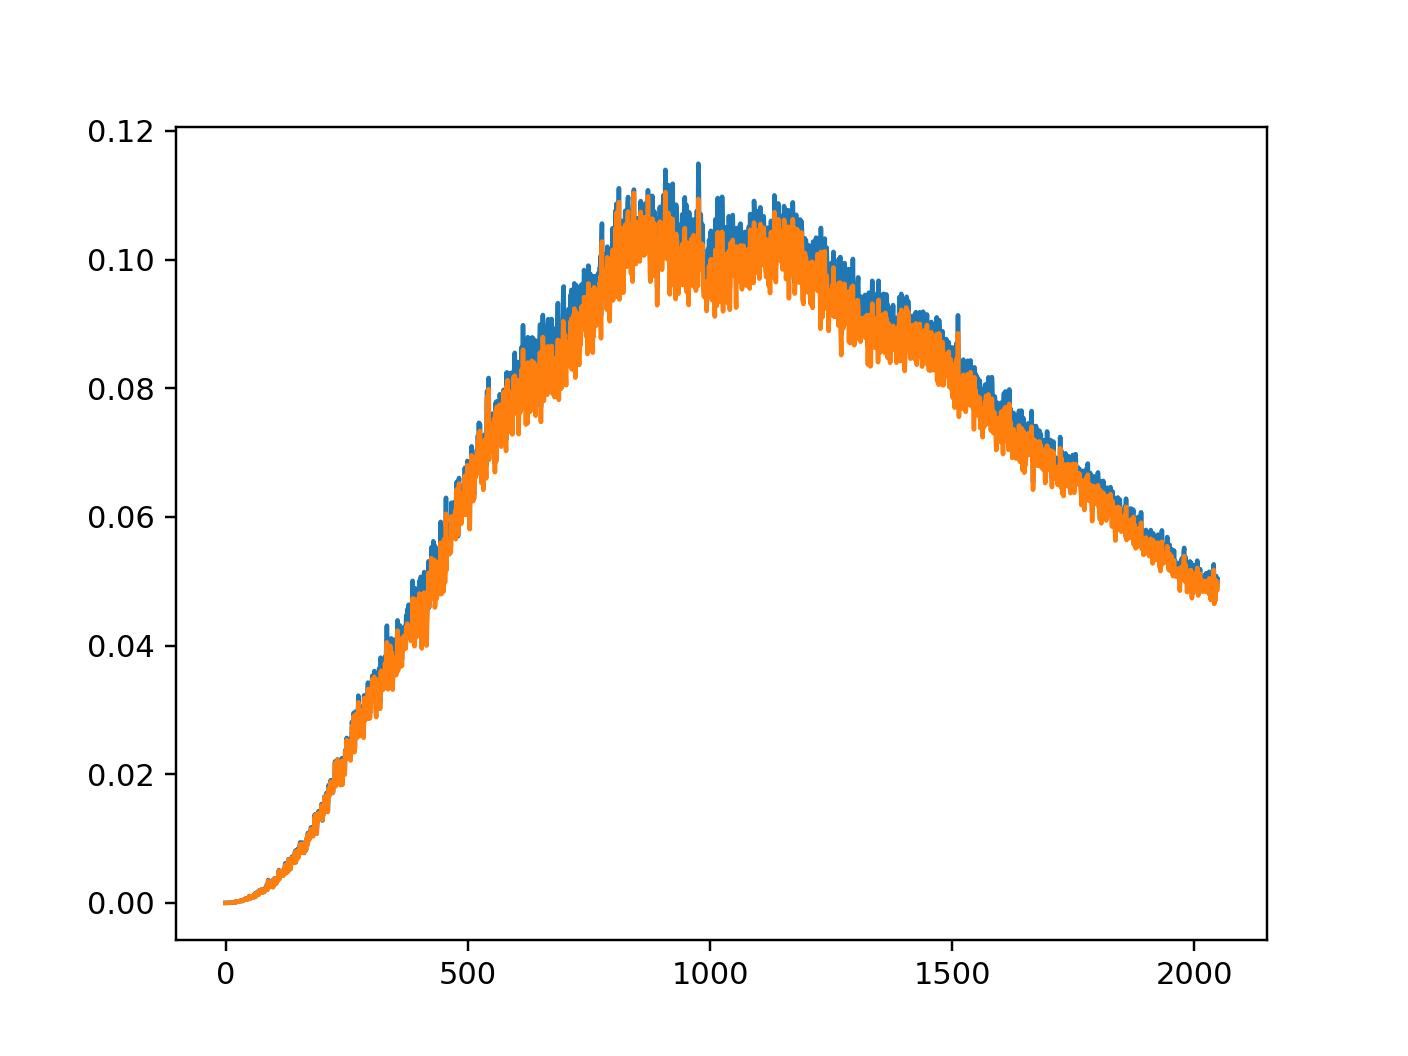

In [160]:
ell=np.arange(lmax+1)
fl=ell*(ell+1)/(2.*pi)

figure()
plot(ell,fl*clobs[2])
plot(ell,fl*clcmb[2])

# Ideal

## EB

In [161]:
eb=eb_rec.opt_eb_qe(cmb,clthr,lmax,Lmax)
eb.eb_reconstruct()

<IPython.core.display.Javascript object>


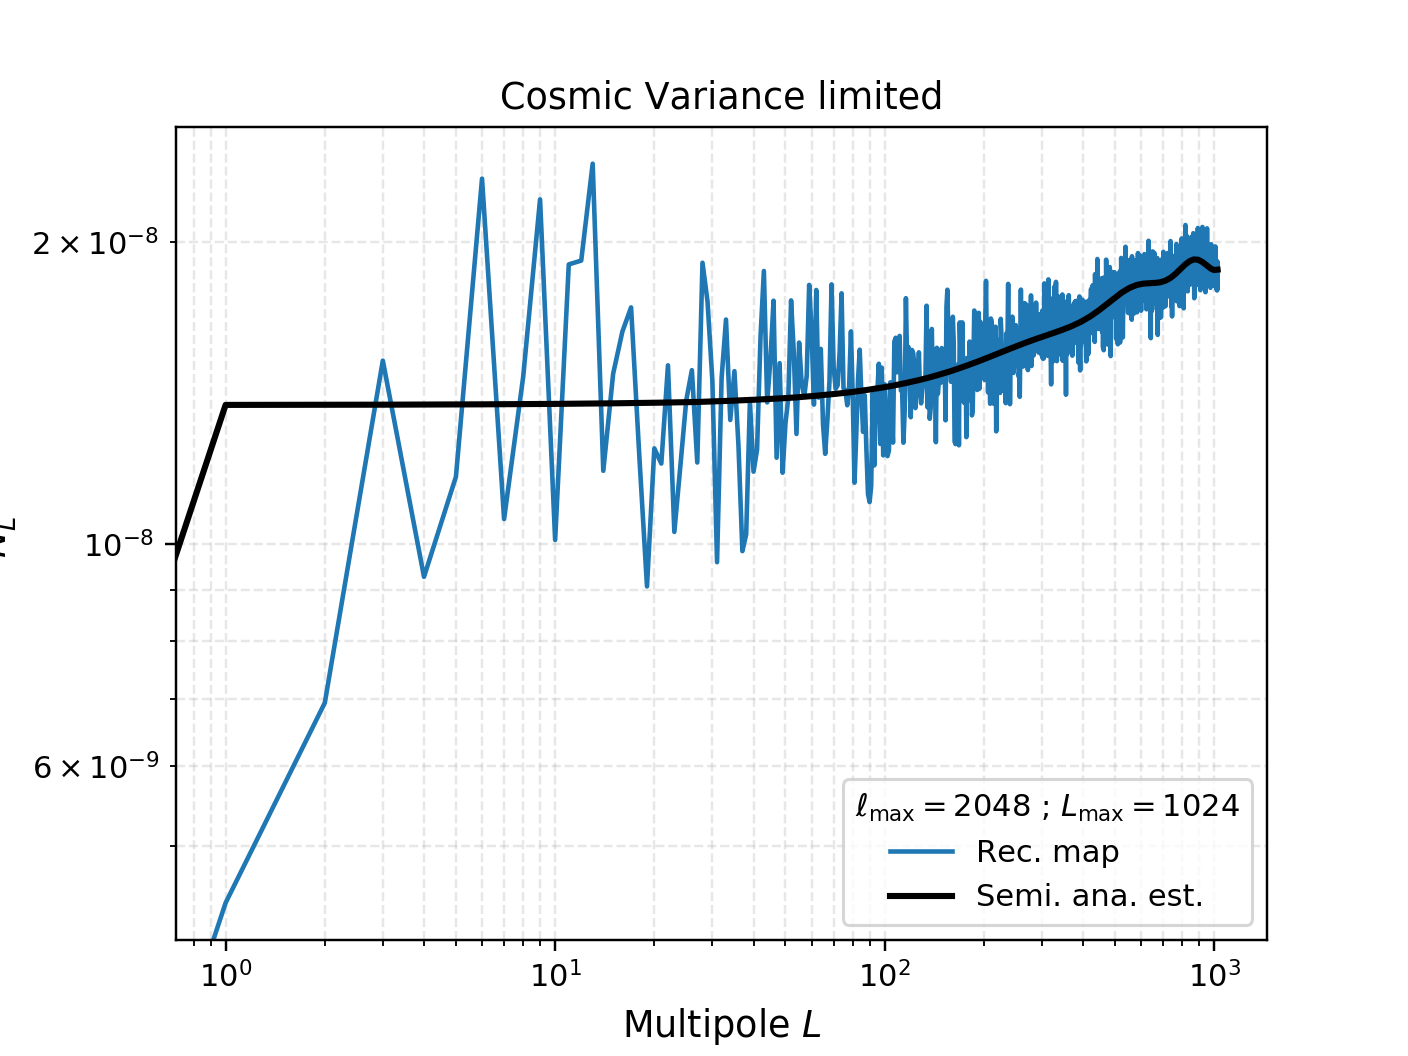

In [162]:
L=np.arange(Lmax+1)
figure()
plot(L,eb.Cl_rec_alpha,label="Rec. map")
plot(L,NLeb,"k-",lw=2,label="Semi. ana. est.")
loglog()
ylabel(r"$N^{\alpha}_L$",fontsize=12)
xlabel(r"Multipole $L$",fontsize=12)
grid(which="both",alpha=0.3,linestyle="dashed")
legend(loc=0,title=r"$\ell_{\rm max}=$" + str(lmax) + " ; " + r"$L_{\rm max}=$"+str(Lmax) )
title("Cosmic Variance limited")
# ylim(1e-8,1e-6)
figname=figpath + "eb_recnoise_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight")

## TB

In [163]:
tb=tb_rec.opt_tb_qe(cmb,clthr,lmax,Lmax)
tb.tb_reconstruct()

<IPython.core.display.Javascript object>


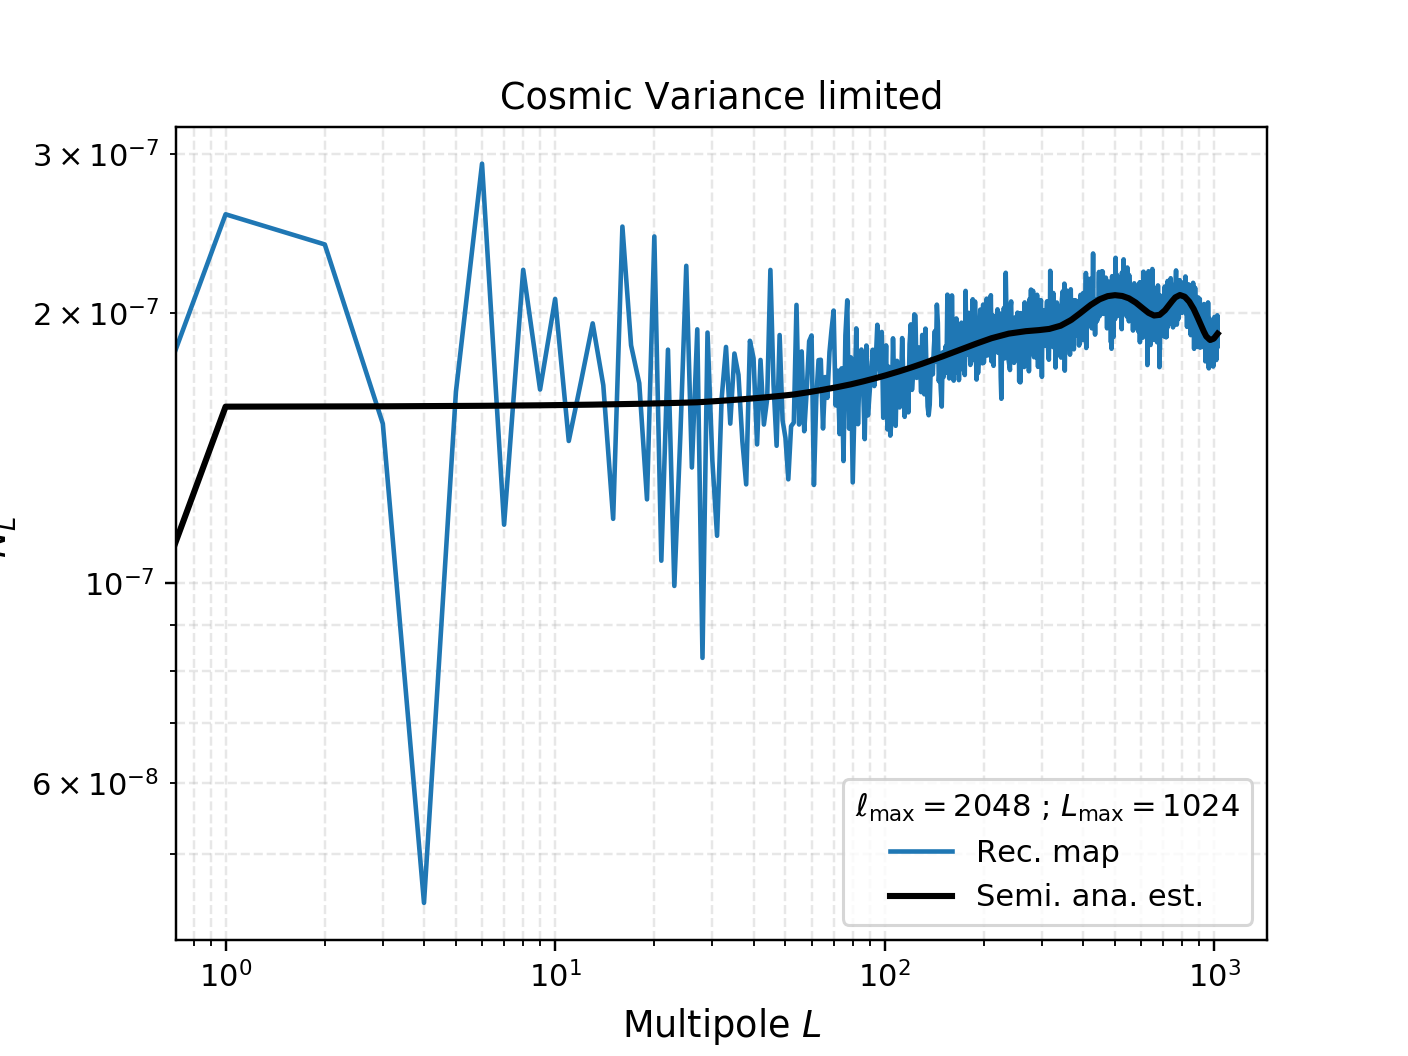

In [164]:
L=np.arange(Lmax+1)
figure()
plot(L,tb.Cl_rec_alpha,label="Rec. map")
plot(L,NLtb,"k-",lw=2,label="Semi. ana. est.")
loglog()
ylabel(r"$N^{\alpha}_L$",fontsize=12)
xlabel(r"Multipole $L$",fontsize=12)
grid(which="both",alpha=0.3,linestyle="dashed")
legend(loc=0,title=r"$\ell_{\rm max}=$" + str(lmax) + " ; " + r"$L_{\rm max}=$"+str(Lmax) )
title("Cosmic Variance limited")
# ylim(1e-8,1e-6)
figname=figpath + "tb_recnoise_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight")

# Birefringence recontruction

In [165]:
eb=eb_rec.opt_eb_qe(obs,clthr,lmax,Lmax)
eb.eb_reconstruct()

In [166]:
tb=tb_rec.opt_tb_qe(obs,clthr,lmax,Lmax)
tb.tb_reconstruct()

<IPython.core.display.Javascript object>


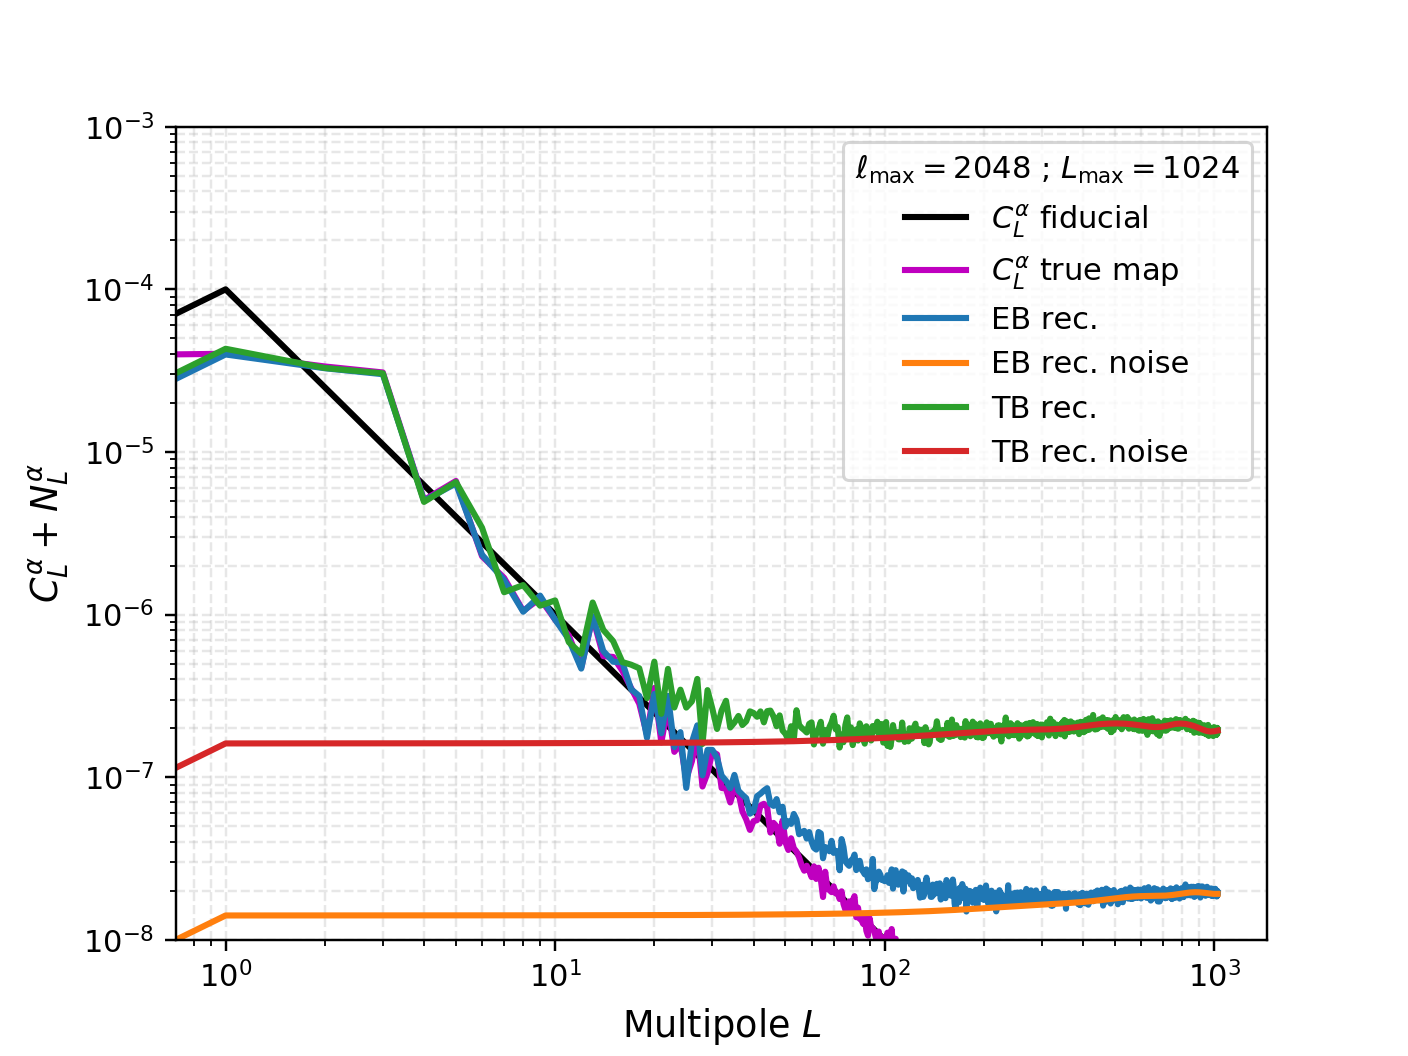

In [167]:
figure()
plot(L,cl_alpha,"k-",lw=2,label=r"$C_{L}^{\alpha}$ fiducial")
plot(L,clsig,"m-",lw=2,label=r"$C_{L}^{\alpha}$ true map")
plot(L,eb.Cl_rec_alpha,lw=2,label="EB rec.")
plot(L,eb.N_L,lw=2,label="EB rec. noise")
plot(L,tb.Cl_rec_alpha,lw=2,label="TB rec.")
plot(L,tb.N_L,lw=2,label="TB rec. noise")
loglog()
ylabel(r"$C_{L}^{\alpha} + N^{\alpha}_L$",fontsize=12)
xlabel(r"Multipole $L$",fontsize=12)
grid(which="both",alpha=0.3,linestyle="dashed")
legend(loc=0,title=r"$\ell_{\rm max}=$" + str(lmax) + " ; " + r"$L_{\rm max}=$"+str(Lmax) )
ylim(1e-8,1e-3)
figname=figpath + "cl_rec_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


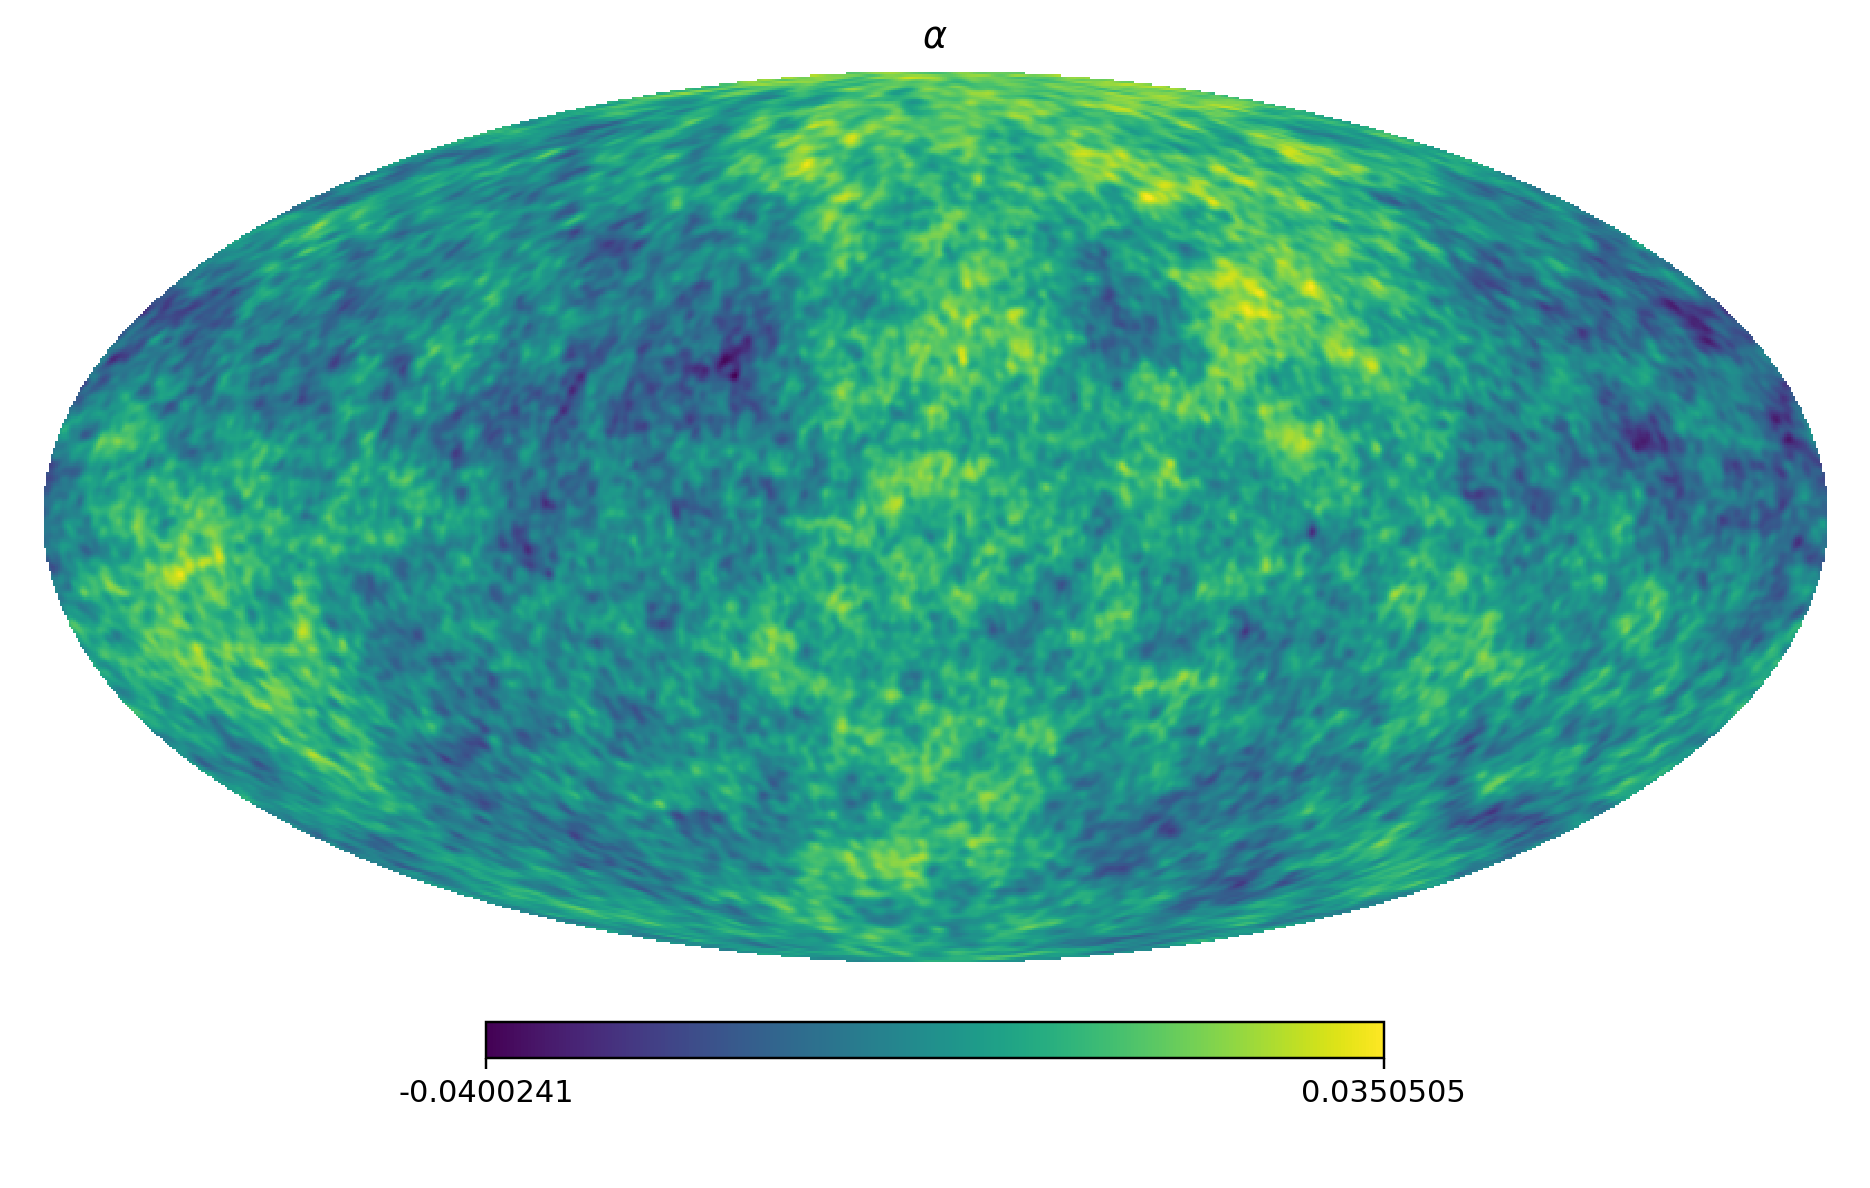

<IPython.core.display.Javascript object>


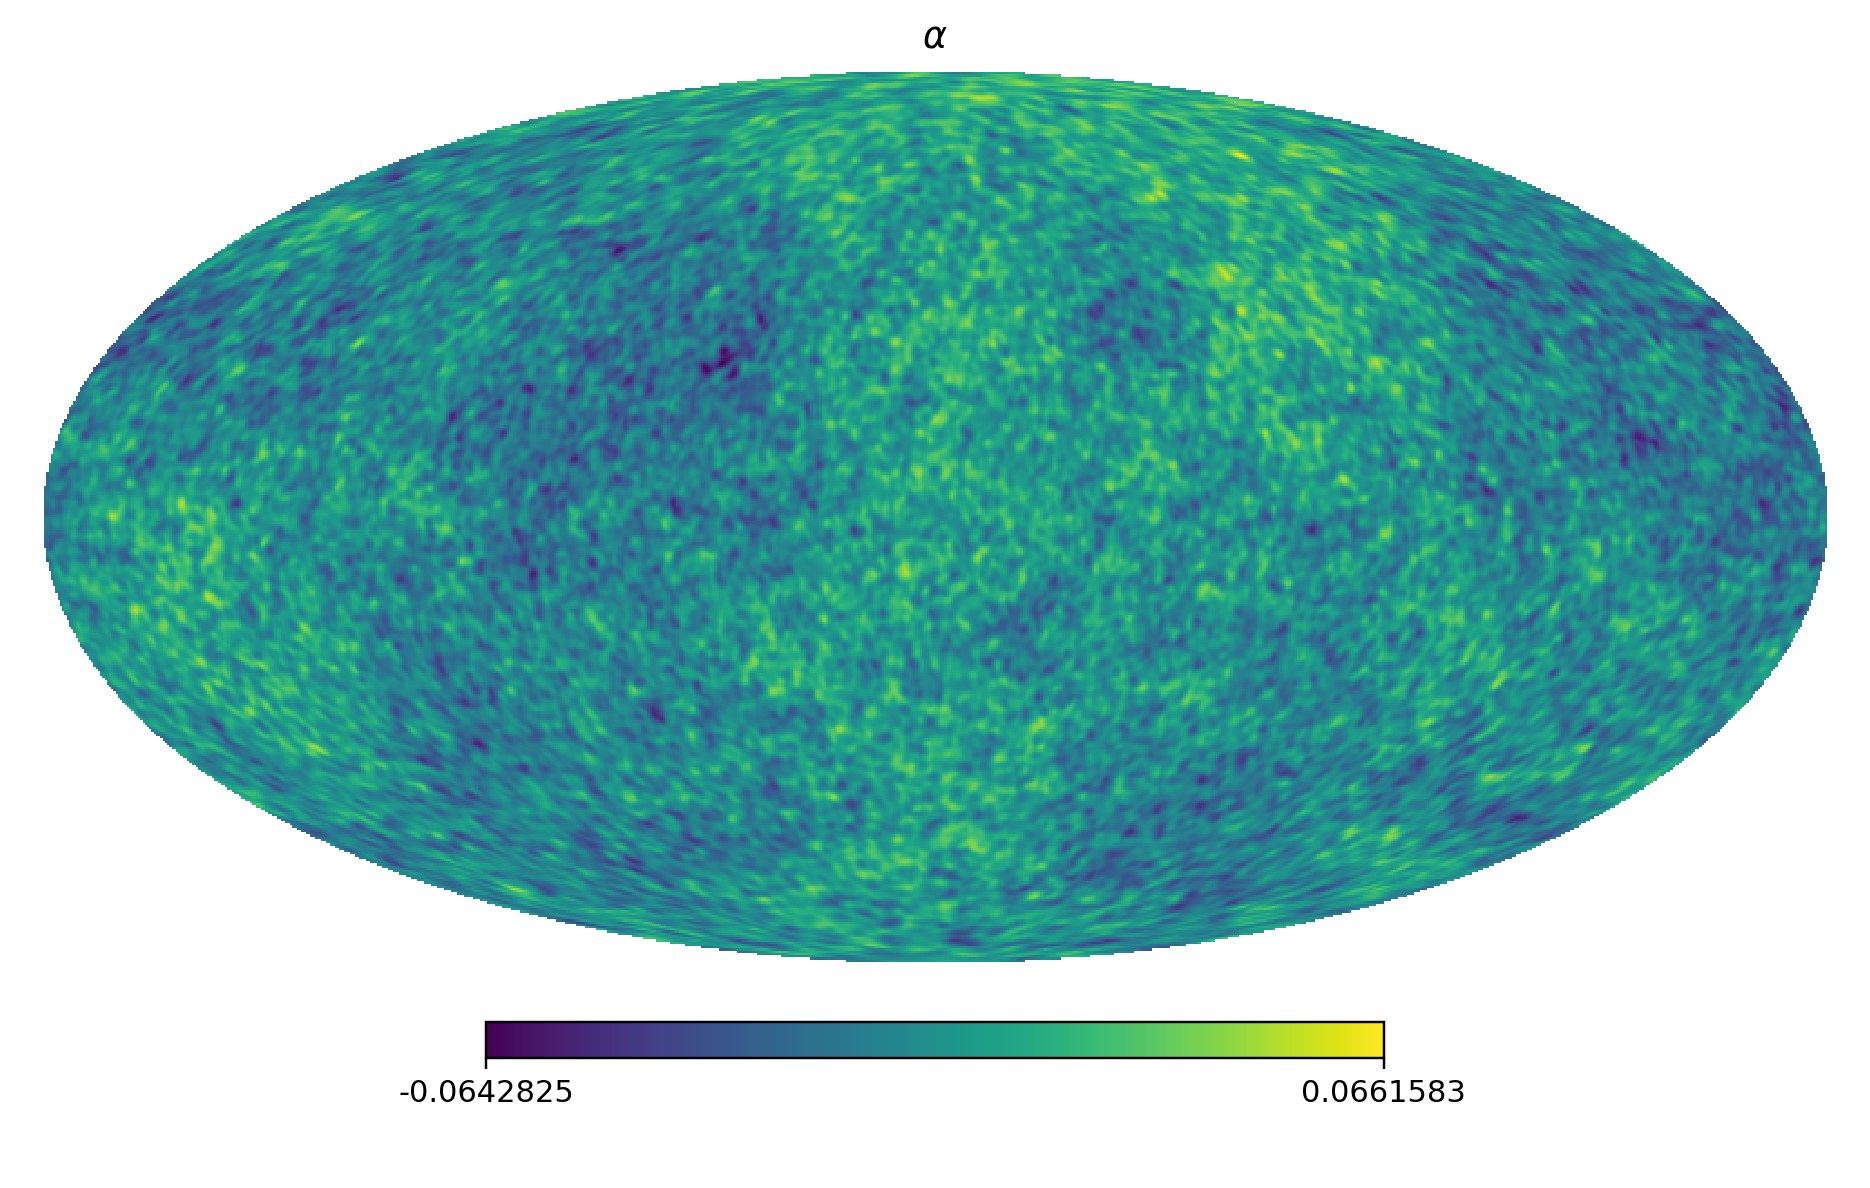

<IPython.core.display.Javascript object>


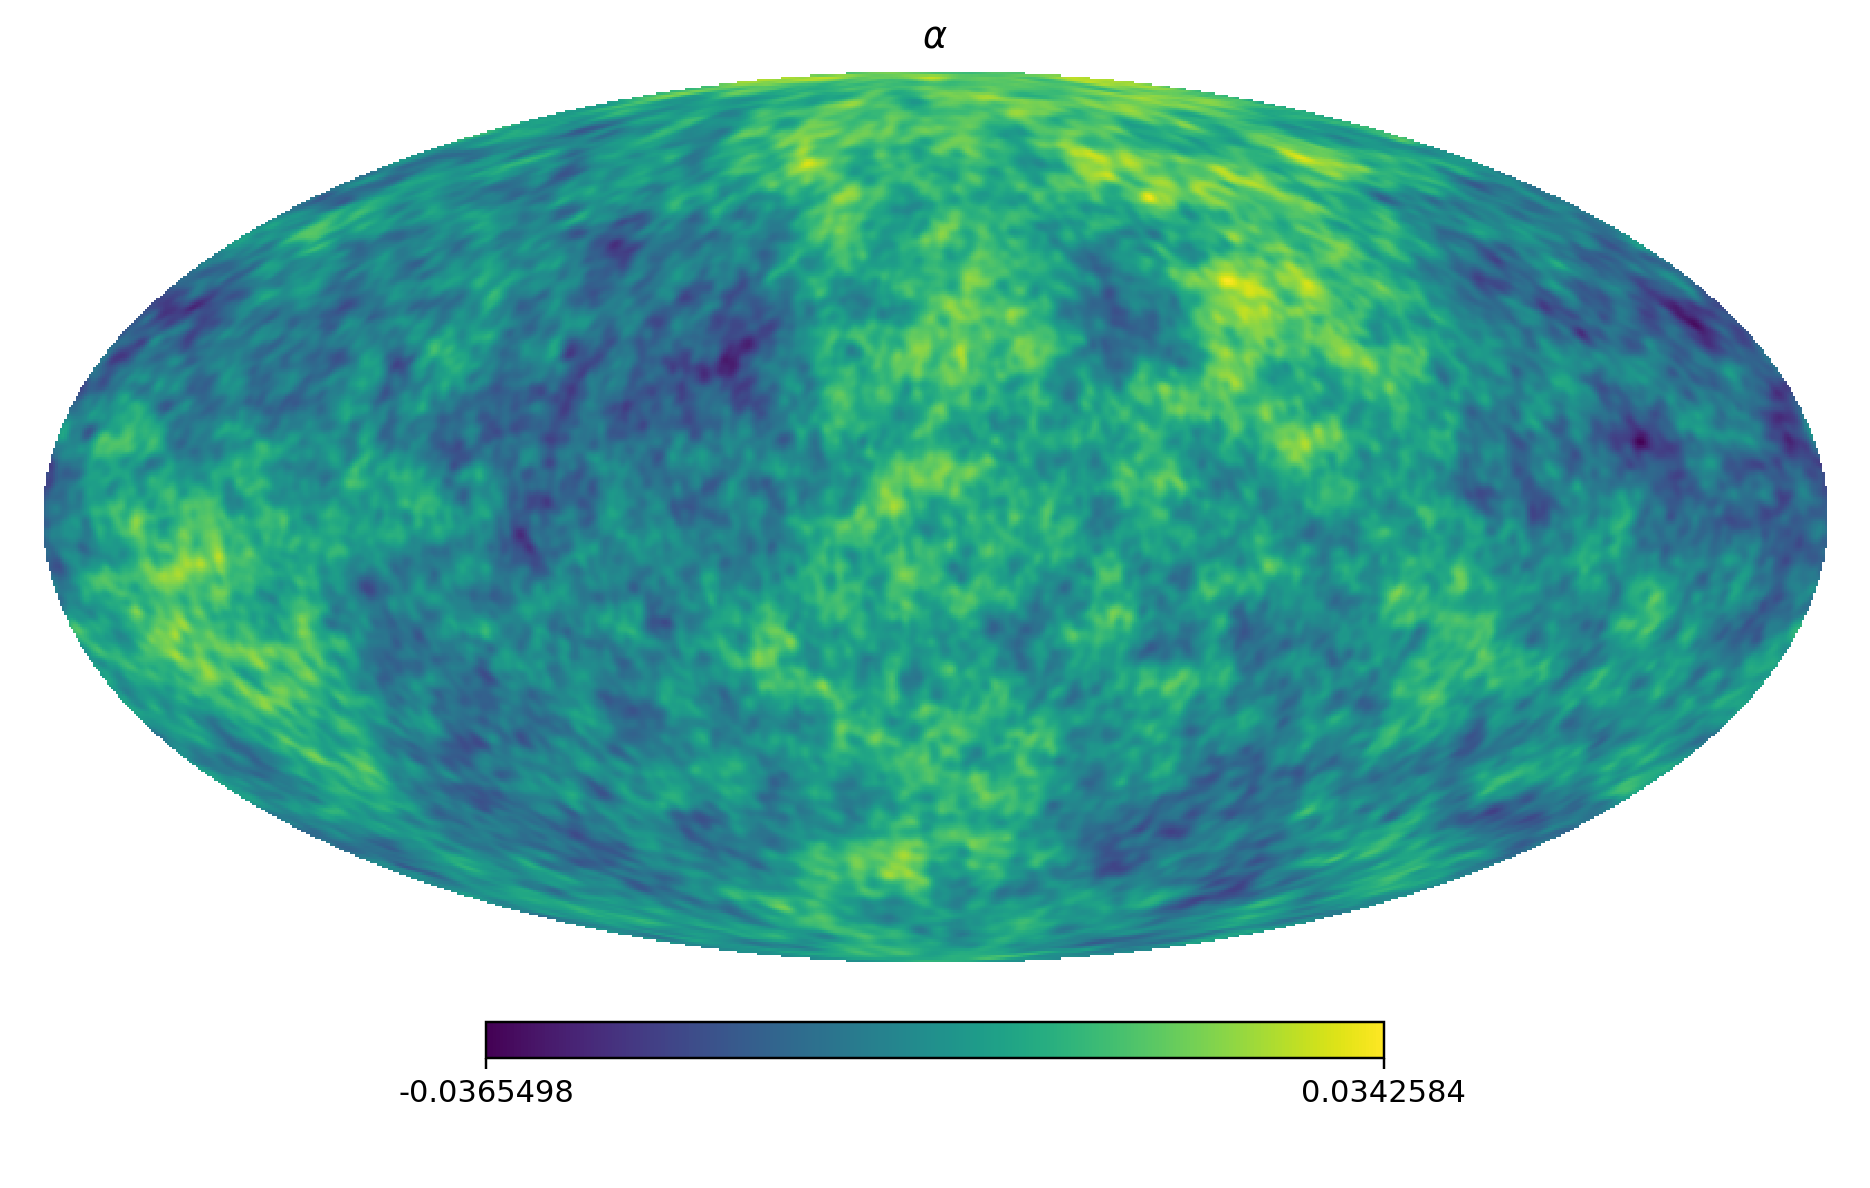

In [168]:
fwhm=90.
h.mollview(h.smoothing(eb.rec_alpha,fwhm=(fwhm/60.)*np.pi/180.,verbose=False),title=r"$\alpha$")
figname=figpath + "eb_rec_alpha_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight")

h.mollview(h.smoothing(tb.rec_alpha,fwhm=(fwhm/60.)*np.pi/180.,verbose=False),title=r"$\alpha$")
figname=figpath + "tb_rec_alpha_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight")

h.mollview(h.smoothing(alpha,fwhm=(fwhm/60.)*np.pi/180.,verbose=False),title=r"$\alpha$")
figname=figpath + "smoothed_alpha.pdf"
savefig(figname,bbox_inches="tight")